In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
    

In [2]:

# Load dataset (make sure the CSV file is in the same directory)
df = pd.read_csv('customer_churn_data.csv')  # Update filename if different

# Convert categorical variables
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Select relevant features
X = df[['Age', 'Gender', 'Tenure', 'MonthlyCharges']]
y = df['Churn']

# Check class distribution
print(y.value_counts())
    

Churn
1    883
0    117
Name: count, dtype: int64


Text(0.5, 1.0, 'Churn (Yes/No)')

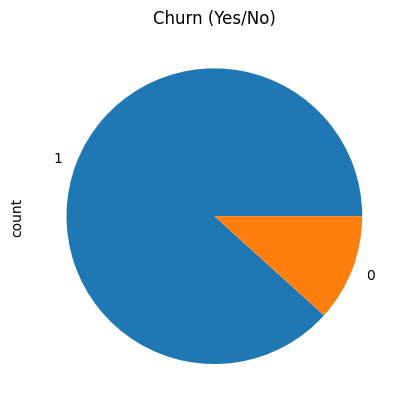

In [3]:
df["Churn"].value_counts().plot(kind='pie')
plt.title("Churn (Yes/No)")

Text(0.5, 1.0, 'Contract Type Average Price')

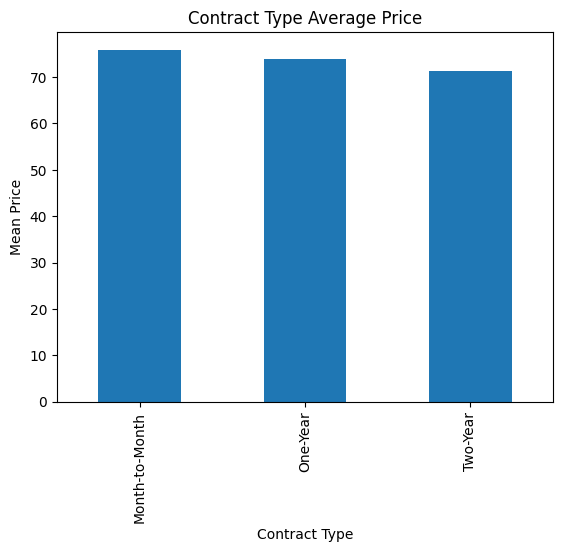

In [4]:
df.groupby("ContractType")["MonthlyCharges"].mean().plot(kind='bar')
plt.ylabel("Mean Price")
plt.xlabel("Contract Type")
plt.title("Contract Type Average Price")

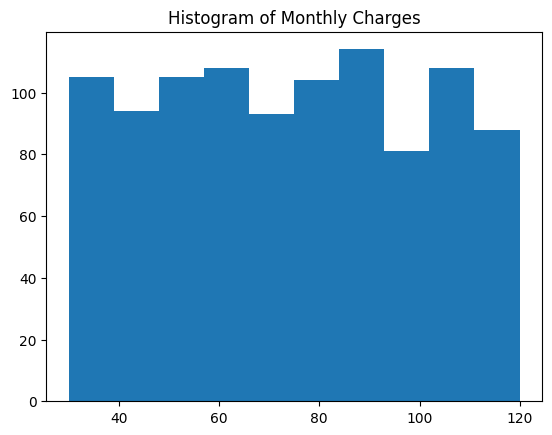

In [5]:
plt.hist(df["MonthlyCharges"])
plt.title("Histogram of Monthly Charges")
plt.show()

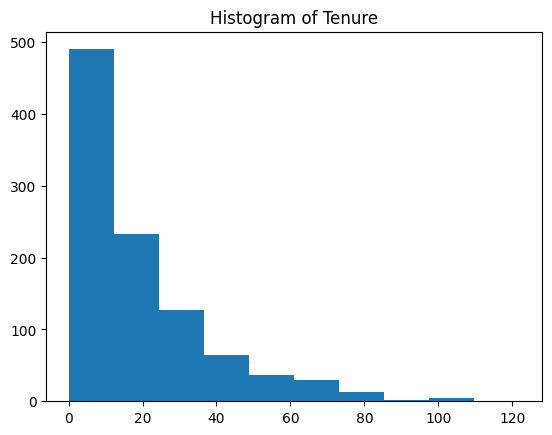

In [6]:
plt.hist(df["Tenure"])
plt.title("Histogram of Tenure")
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def modelperformance(y_true, predictions, proba=None):
    acc = accuracy_score(y_true, predictions)
    print("Accuracy       :", round(acc, 2))
    print("Precision      :", round(precision_score(y_true, predictions), 2))
    print("Recall         :", round(recall_score(y_true, predictions), 2))
    print("F1 Score       :", round(f1_score(y_true, predictions), 2))
    if proba is not None:
        print("ROC AUC Score  :", round(roc_auc_score(y_true, proba), 2))
    print("\nClassification Report:\n", classification_report(y_true, predictions))
    return acc



In [8]:


# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(probability=True)
}

accuracies = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"🔍 {name}")
    acc = modelperformance(y_test, y_pred, y_proba)
    accuracies[name] = acc
    print("-" * 60)


🔍 Logistic Regression
Accuracy       : 0.88
Precision      : 0.88
Recall         : 0.99
F1 Score       : 0.93
ROC AUC Score  : 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.88      0.99      0.93       177

    accuracy                           0.88       200
   macro avg       0.44      0.49      0.47       200
weighted avg       0.78      0.88      0.83       200

------------------------------------------------------------
🔍 Decision Tree
Accuracy       : 0.81
Precision      : 0.9
Recall         : 0.88
F1 Score       : 0.89
ROC AUC Score  : 0.57

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.26      0.24        23
           1       0.90      0.88      0.89       177

    accuracy                           0.81       200
   macro avg       0.56      0.57      0.57       200
weighted avg       0.82      0.81 

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

In [10]:
best_model = max(accuracies, key=accuracies.get)
print(f"✅ Best model by accuracy: {best_model} ({accuracies[best_model]:.2f})")


✅ Best model by accuracy: SVC (0.89)


In [11]:

from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", np.bincount(y_train_bal))
    

After SMOTE: [706 706]


In [12]:

# Train model on balanced data
model = SVC(probability=True, kernel='rbf', C=1)
model.fit(X_train_bal, y_train_bal)

# Evaluate
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.27      0.83      0.41        23
           1       0.97      0.71      0.82       177

    accuracy                           0.72       200
   macro avg       0.62      0.77      0.61       200
weighted avg       0.89      0.72      0.77       200



In [13]:

# Save the model and scaler
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler exported successfully.")
    

Model and scaler exported successfully.
